## GANs for unpaired I2I translation

Unpaired domain transfer is a challenging task. In this notebook I train Least Squares GAN using L1 regularization ($\|G(x)-x\|_1$) on the MNIST and USPS datasets and demonstrate that this model successfully handles unpaired domain transfer.

### 1. Implementation of samplers/dataloaders for the dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, USPS
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
from torchvision.utils import make_grid
from copy import deepcopy
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
import warnings
warnings.filterwarnings("ignore")

Auxiliary functions to initialize samplers

In [2]:
class Sampler:
    def __init__(
        self, device='cuda',
    ):
        self.device = device

    def sample(self, size=5):
        pass

class LoaderSampler(Sampler):
    def __init__(self, loader, device='cuda'):
        super(LoaderSampler, self).__init__(device)
        self.loader = loader
        self.it = iter(self.loader)

    def sample(self, size=5):
        assert size <= self.loader.batch_size
        try:
            batch, _ = next(self.it)
        except StopIteration:
            self.it = iter(self.loader)
            return self.sample(size)
        if len(batch) < size:
            return self.sample(size)

        return batch[:size].to(self.device)

100%|██████████| 6.58M/6.58M [00:04<00:00, 1.42MB/s]


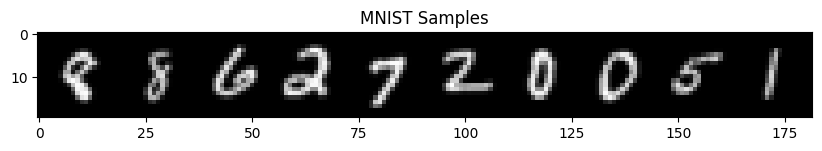

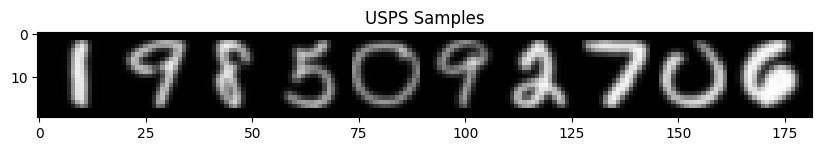

In [ ]:
transform = transforms.Compose([
    transforms.Resize(16),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

mnist_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
usps_dataset = USPS(root='./data', train=True, download=True, transform=transform)

batch_size = 64

mnist_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
usps_loader = DataLoader(usps_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

mnist_sampler = LoaderSampler(mnist_loader, DEVICE)
usps_sampler = LoaderSampler(usps_loader, DEVICE)

def show_batch(sampler, title):
    sample = sampler.sample(10)
    grid = make_grid(sample, nrow=10, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(np.asarray(grid.permute(1, 2, 0).cpu()))

show_batch(mnist_sampler, "MNIST Samples")
show_batch(usps_sampler, "USPS Samples")

### 2. Implementation of generator and discriminator for GAN

 The generator model $G(x)$ takes MNIST image $x$ as input. For the discriminator model, I use an unconditional discriminator $D(y)$.

In [11]:
G = nn.Sequential(
    nn.Conv2d(1, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 1, kernel_size=5, padding=2),
)

G = G.to(DEVICE)

In [12]:
class SimplePatchDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=4, padding=1, stride=2),
            nn.InstanceNorm2d(128), # 128 x 8 x 8
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, padding=1, stride=2),
            nn.InstanceNorm2d(256), #  256 x 4 x 4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, padding=1, stride=2),
            nn.InstanceNorm2d(512), # 512 x 2 x 2
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=1, padding=0), # 1 x 2 x 2
        )
        self.output_shape = (1, 2, 2)

    def forward(self, x):
        return self.net(x)

D = SimplePatchDiscriminator()
D = D.to(DEVICE)

### 3. Implementation of GAN model training for MNIST->USPS translation task.

In the unpaired domain transfer task, we want to train a generative adversarial model such that the generator $G$, receiving a batch of MNIST digits $x$ as input, generates USPS digits $G(x)$ similar to $x$. Such similarity can be achieved in different ways. For example, the authors of the CycleGAN paper used the so-called cycle consistency loss. However, this approach is resource-intensive since it requires considering 2 generators and 2 discriminators simultaneously. Further, I show that there is a simpler way to solve the unpaired domain transfer task using $L1$ loss between input and generated images.

Auxiliary functions for tracking the GAN training process

In [13]:
def plot_images(batch_x, title = None):
    fig, axes = plt.subplots(1, 10, figsize=(10, 2))
    if title is not None:
        fig.suptitle(title)
    for i in range(10):
        axes[i].imshow(batch_x[i].squeeze(), cmap='gray')
        axes[i].set_xticks([]); axes[i].set_yticks([])
    fig.tight_layout(pad=0.1)
    plt.show()


def plot_losses(gen_losses, disc_losses):
    fig, axes  = plt.subplots(1,2, figsize=(10, 3))
    axes[0].plot(gen_losses)
    axes[0].set_title('Generator Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].grid('on')

    axes[1].plot(disc_losses)
    axes[1].set_title('Discriminator Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].grid('on')
    plt.show()

I use Least Squares GAN loss. When training the generator, I use $L1$ regularization defined as the norm of the difference between input ($x$) and generated ($G(x)$) images: $\|G(x)-x\|_1$.

In [ ]:
# GAN loss and L1 loss

criterion = nn.MSELoss()
l1_loss = nn.L1Loss()

In [ ]:
# Initialization of the optimizers
LR = 2e-4
BETA1 = 0.5
BETA2 = 0.999

optimizerG = Adam(G.parameters(), lr=LR, betas=(BETA1, BETA2))
optimizerD = Adam(D.parameters(), lr=LR, betas=(BETA1, BETA2))

In [ ]:
# Setting hyper-parameters for training

MAX_STEPS = 6000 + 1
BATCH_SIZE = 64
DISC_STEPS = 1        # steps for generator update
VIS_STEPS = 50        # steps for visualization
L1_LAMBDA = 1         # weight of regularization

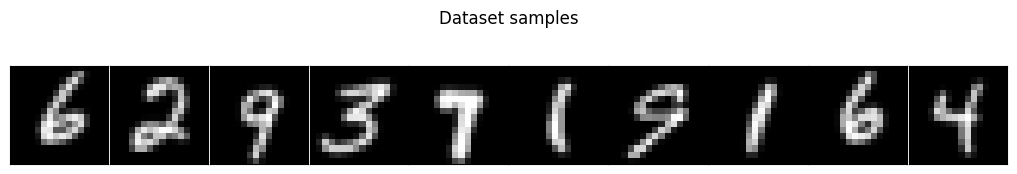

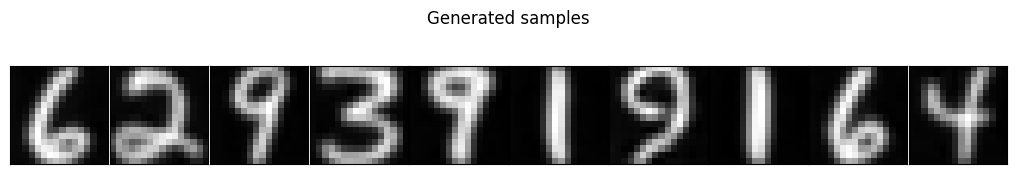

Step: 6000, G loss: 0.7738128853348807, D loss: 0.18765725001725053


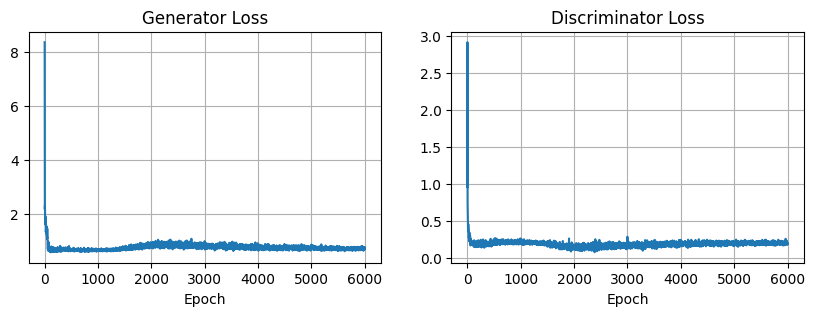

100%|██████████| 6001/6001 [06:15<00:00, 16.00it/s]


In [ ]:
disc_losses = []
gen_losses = []

for step in tqdm(range(MAX_STEPS)):

    # model input
    mnist_images = mnist_sampler.sample(BATCH_SIZE)
    usps_images = usps_sampler.sample(BATCH_SIZE)

    valid = torch.ones((BATCH_SIZE, *D.output_shape), device=DEVICE)
    fake = torch.zeros((BATCH_SIZE, *D.output_shape), device=DEVICE)

    ##################
    # Train Discriminator
    D.train()
    G.eval()
    D.zero_grad()

    scores_real = D(usps_images)
    loss_real = criterion(scores_real, valid)

    fake_images = G(mnist_images).detach()
    scores_gen = D(fake_images)
    loss_fake = criterion(scores_gen, fake)

    loss_D = (loss_real + loss_fake) / 2
    loss_D.backward()
    optimizerD.step()
    disc_losses.append(loss_D.item())

    # Train Generator
    if step % DISC_STEPS == 0:
        G.train()
        D.eval()
        G.zero_grad()

        mnist_images = mnist_sampler.sample(BATCH_SIZE)

        fake_images = G(mnist_images)
        scores_gen = D(fake_images)
        loss_GAN = criterion(scores_gen, valid)

        # L1 regularization
        #usps_images = usps_sampler.sample(BATCH_SIZE)
        l1_reg = l1_loss(G(mnist_images), mnist_images)
        loss_G = loss_GAN + L1_LAMBDA * l1_reg
        loss_G.backward()
        optimizerG.step()
        gen_losses.append(loss_G.item())

    if step % VIS_STEPS == 0:
        with torch.no_grad():
            clear_output()

            plot_images(mnist_images[:10].detach().cpu(),'Dataset samples')

            G.eval()
            X_gen = G(mnist_images[:10].to(DEVICE))
            plot_images(X_gen.detach().cpu(), 'Generated samples')

            print(f"Step: {step}, G loss: {np.mean(gen_losses)}, D loss: {np.mean(disc_losses)}")
            plot_losses(gen_losses, disc_losses)

### 4. Evaluation of model results

#### 4.1 Qualitative results of GAN model

In [ ]:
transform = transforms.Compose([
    transforms.Resize(16),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

mnist_test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
usps_test_dataset = USPS(root='./data', train=False, download=True, transform=transform)

batch_size = 10

mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
usps_test_loader = DataLoader(usps_test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

100%|██████████| 1.83M/1.83M [00:02<00:00, 816kB/s] 


In [ ]:
mnist_images, _= next(iter(mnist_loader))
usps_images, _= next(iter(usps_loader))

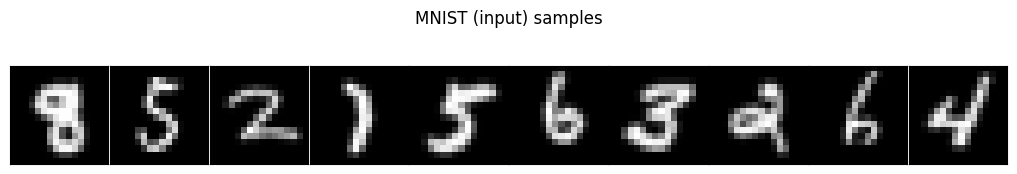

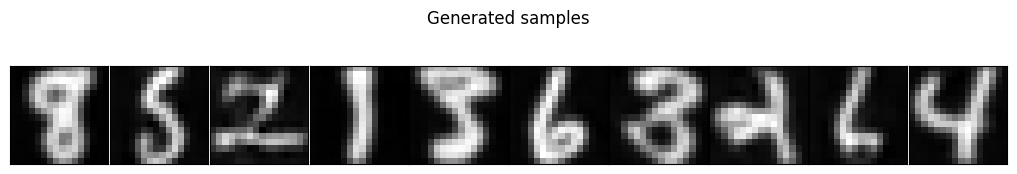

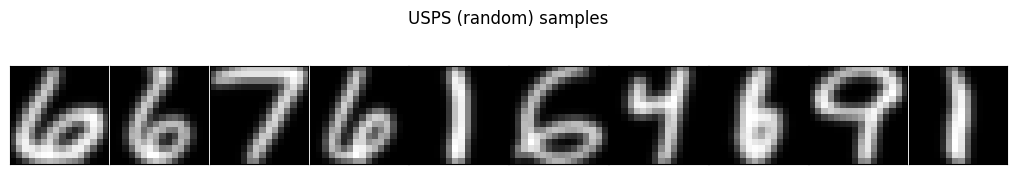

In [ ]:
# <visualization of the results for trained models>
# 1st row - MNIST test samples
# 2d row - corresponding generated USPS samples
# 3d row - USPS test samples
with torch.no_grad():
    plot_images(mnist_images, 'MNIST (input) samples')

    G.eval()
    X_gen = G(mnist_images.to(DEVICE))
    plot_images(X_gen.detach().cpu(), 'Generated samples')

    plot_images(usps_images, 'USPS (random) samples')

#### 4.2 Summary

As can be seen from the generated images, it is quite possible to use Least Squares GAN with L1 regularization for unpaired domain translation tasks, at least when the domains are simple, like handwritten digits. During training, it is important that L1 regularization compares elements of the initial distribution with the generator's output on the same elements. Visually, the generated images are almost indistinguishable from elements of the target domain (perhaps just slightly more blurry). Thus, thanks to L1 regularization, we managed to solve the domain translation task using fewer models (2 instead of 4 described in the CycleGAN paper) and a significantly simpler loss instead of cycle consistency loss.